In [11]:
import tensorflow as tf
import os, glob
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
random.seed(5)

classes = ["Gryffindor","Ravenclaw","Hufflepuff","Slytherin"]
num_classes = len(classes)
image_size = 100

traindatadir = './image/train/'
validdatadir = './image/valid/'
testdatadir = './image/test/'

x = []
y = []

x_train = []
y_train = []
x_valid = []
y_valid = []
x_test = []
y_test = []

for index, classlabel in enumerate(classes):
    photosdir = traindatadir + classlabel
    files = glob.glob(photosdir + "/*.png")
    #new_files = random.sample(files,len(files))
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        #image.save("./test/{}{}.jpg".format(classlabel,i))
        data = np.asarray(image)
        x_train.append(data)
        y_train.append(index)

for index, classlabel in enumerate(classes):
    photosdir = validdatadir + classlabel
    files = glob.glob(photosdir + "/*.png")
    new_files = random.sample(files,len(files))
    for i, file in enumerate(new_files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        #image.save("./test/{}{}.jpg".format(classlabel,i))
        data = np.asarray(image)
        x_valid.append(data)
        y_valid.append(index)

for index, classlabel in enumerate(classes):
    photosdir = testdatadir + classlabel
    files = glob.glob(photosdir + "/*.png")
    new_files = random.sample(files,len(files))
    for i, file in enumerate(new_files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        #image.save("./test/{}{}.jpg".format(classlabel,i))
        data = np.asarray(image)
        x_test.append(data)
        y_test.append(index)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_train.shape)

ds_train = tf.data.Dataset.from_tensor_slices((x_train,y_train))
ds_valid = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))
ds_test = tf.data.Dataset.from_tensor_slices((x_test,y_test))

tf.random.set_seed(1)

(240, 100, 100, 3)


In [12]:
def preprocess(x1,x2, size=(64, 64), mode='train'):
    image = x1
    label = x2
    if mode == 'train':
        image_cropped = tf.image.random_crop(image, size=(88, 88, 3))
        image_resized = tf.image.resize(image_cropped, size=size)
        image_flip = tf.image.random_flip_left_right(image_resized)
        return (image_flip/255.0, tf.cast(label, tf.int32))
    else:
        image_resized = tf.image.resize(
            image, size=size)
        return (image_resized/255.0, tf.cast(label, tf.int32))

BATCH_SIZE = 32
BUFFER_SIZE = 240
IMAGE_SIZE = (64, 64)
steps_per_epoch = np.ceil(640/BATCH_SIZE)
print(steps_per_epoch)

ds_train = ds_train.map(
    lambda x,y: preprocess(x,y, size=IMAGE_SIZE, mode='train'))
ds_train = ds_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)

ds_valid = ds_valid.map(
    lambda x,y: preprocess(x,y, size=IMAGE_SIZE, mode='eval'))
ds_valid = ds_valid.batch(BATCH_SIZE)

ds_test = ds_test.map(
    lambda x,y: preprocess(x,y, size=IMAGE_SIZE, mode='test'))
ds_test = ds_test.batch(BATCH_SIZE)


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(
    rate=0.5),
    
    tf.keras.layers.Conv2D(
        64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(
    rate=0.5),

    tf.keras.layers.Conv2D(
    128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(
    256, (3, 3), padding='same', activation='relu'),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'),

    tf.keras.layers.Dropout(
    rate=0.5),

    tf.keras.layers.Dense(
    units=4, name='fc_2',
    activation='softmax')
])

'''
tf.keras.layers.Conv2D(
    128, (3, 3), padding='same', activation='relu'),
tf.keras.layers.MaxPooling2D((2, 2)),

tf.keras.layers.Conv2D(
    256, (3, 3), padding='same', activation='relu'),
'''

'''model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))
    
model.add(tf.keras.layers.Dense(
    units=4, name='fc_2',
    activation='softmax'))'''

model.build(input_shape=(None, 64, 64, 3))

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_valid, 
                    epochs=100, steps_per_epoch=steps_per_epoch)

20.0
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 64)  

"model.compile(optimizer=tf.keras.optimizers.Adam(),\n              loss=tf.keras.losses.SparseCategoricalCrossentropy(),\n              metrics=['accuracy'])\n\nhistory = model.fit(ds_train, validation_data=ds_valid, \n                    epochs=100, steps_per_epoch=steps_per_epoch)"

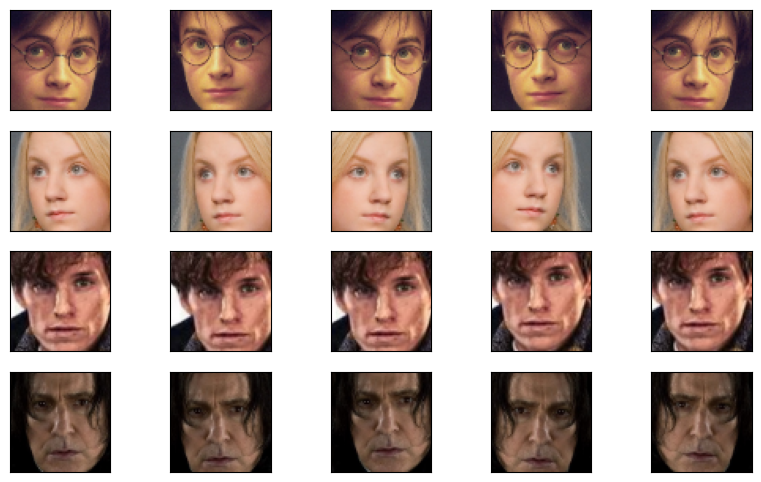

In [8]:
tf.random.set_seed(1)

#ds = ds_train.shuffle(300, reshuffle_each_iteration=False)
ds1 = ds_train.skip(26).take(1)
ds2 = ds_train.skip(81).take(1)
ds3 = ds_train.skip(149).take(1)
ds4 = ds_train.skip(180).take(1)
ds = ds1.concatenate(ds2.concatenate(ds3.concatenate(ds4))).repeat(5)

ds = ds.map(lambda x,y:preprocess(x,y, size=(64, 64), mode='train'))

fig = plt.figure(figsize=(10, 6))
for j,example in enumerate(ds):
    ax = fig.add_subplot(4, 5, j//4+(j%4)*5+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0])
    
plt.savefig('train_image.png', dpi=300)
plt.show()

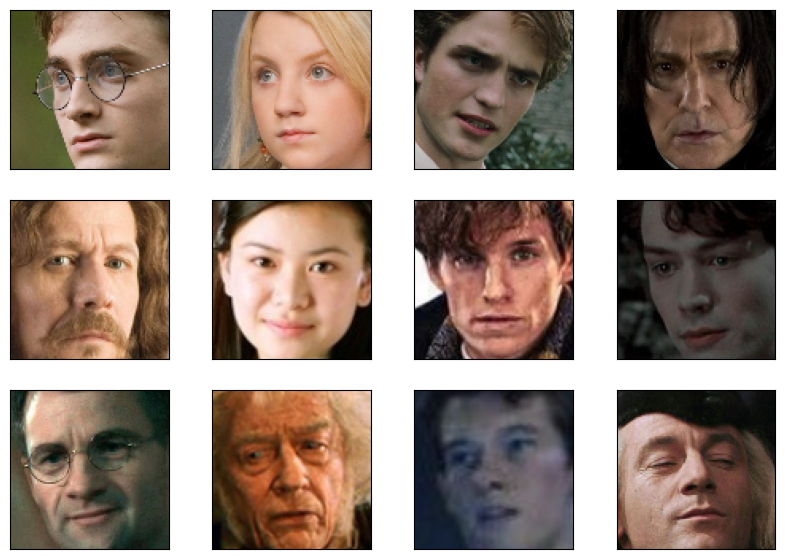

In [699]:
tf.random.set_seed(1)

ds1 = ds_train.skip(19).take(3)
ds2 = ds_train.skip(81).take(3)
ds3 = ds_train.skip(148).take(3)
ds4 = ds_train.skip(180).take(3)
ds = ds1.concatenate(ds2.concatenate(ds3.concatenate(ds4)))

#ds = ds.map(lambda x,y:preprocess(x,y, size=(64, 64), mode='train'))

fig = plt.figure(figsize=(10, 7))
for j,example in enumerate(ds):
    ax = fig.add_subplot(3, 4, j//3+(j%3)*4+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0])
    
plt.savefig('train_image.png', dpi=300)
plt.show()

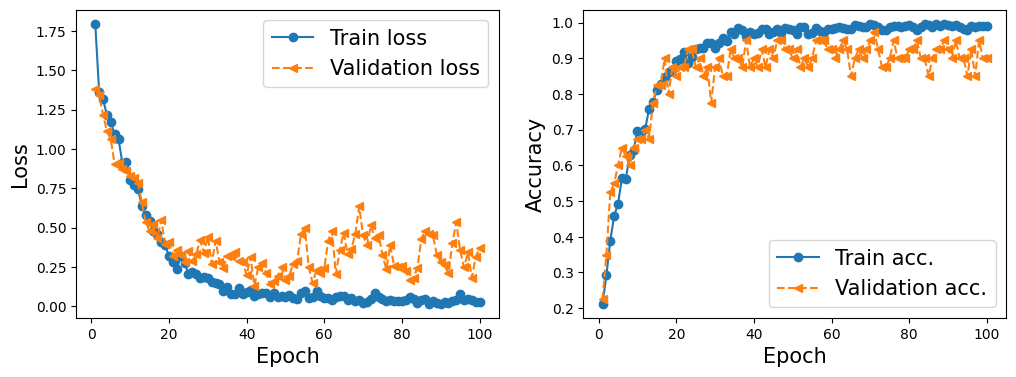

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.savefig('sh1.png', dpi=300)
#plt.show()

In [ ]:

results = model.evaluate(ds_test)
print('Test Acc: {:.2f}%'.format(results[1]*100))

2/2 [==============================] - 0s 8ms/step - loss: 0.2759 - accuracy: 0.9000
Test Acc: 90.00%


TensorShape([3, 4])
tf.Tensor([0 0 2], shape=(3,), dtype=int64)


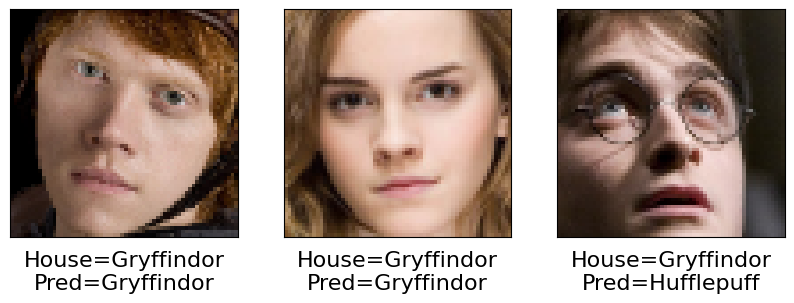

In [714]:
ds1 = ds_test.unbatch().skip(1).take(2)
ds2 = ds_test.unbatch().skip(7).take(1)
ds = ds1.concatenate(ds2)

'''pred_logits = model.predict(ds.batch(10))
probas = tf.nn.softmax(pred_logits)'''
probas = model(next(iter(ds.batch(3)))[0])
tf.print(probas.shape)
preds = tf.argmax(probas,axis=1)
print(preds)

fig = plt.figure(figsize=(10, 4))
for j,example in enumerate(ds):
    ax = fig.add_subplot(1, 3, j+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0])
    if example[1].numpy() == 0:
        label='Gryffindor'
    elif example[1].numpy() == 1:
        label = 'Ravenclaw'
    elif example[1].numpy() == 2:
        label = 'Hufflepuff'
    elif example[1].numpy() == 3:
        label = 'Slytherin'
    ax.text(
        0.5, -0.15, 
        'House={:s}\nPred={:s}'.format(label, classes[preds[j]]), 
        size=16, 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
plt.savefig('gryffindor_test3.png', dpi=300)
plt.show()

In [ ]:
model.save('sorting_hat_classifier1.h5',
           overwrite=True,
           include_optimizer=True,
           save_format='h5')

/Users/tomoyuki/.pyenv/versions/3.8.12/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
